In [1]:

import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
import obspy

import torch
from chronos import ChronosPipeline
import numpy as np

In [15]:
prediction_length = 64

In [3]:
# Create a client to connect to the SCEDC data center
client = Client("SCEDC")

# download a SCEDC earthquake catalog using obspy
starttime = obspy.UTCDateTime("2016-01-01")
endtime = obspy.UTCDateTime("2020-01-01")
minlatitude = 32.0
minlongitude = -125.0
maxlatitude = 42.0
maxlongitude = -114.0
minmagnitude = 2.7
quake_catalog = client.get_events(starttime=starttime,\
             endtime=endtime, minlatitude=minlatitude, \
                minlongitude=minlongitude, maxlatitude=maxlatitude, \
                    maxlongitude=maxlongitude, minmagnitude=minmagnitude)

In [4]:
# next, we will count the number of events per day and store that as a pandas data frame with a datetme index
from collections import Counter
from pandas import DataFrame, to_datetime
import pandas as pd

# Extract event times
event_times = [event.origins[0].time.date for event in quake_catalog]

# Count the number of events per day
event_counts = Counter(event_times)

# Convert the counts to a pandas DataFrame
event_counts_df = DataFrame.from_dict(event_counts, orient='index', columns=['target'])

# Convert the index to datetime
event_counts_df.index = to_datetime(event_counts_df.index)

# Sort the DataFrame by date
event_counts_df = event_counts_df.sort_index()

# Print the DataFrame
print(event_counts_df)

            target
2020-01-01       2
2020-01-02       2
2020-01-03       1
2020-01-04       1
2020-01-05       2
...            ...
2023-12-23       2
2023-12-25       1
2023-12-26       2
2023-12-27       5
2023-12-30       2

[708 rows x 1 columns]


In [5]:
# Identify the frequency of your time series
freq = 'D'  # Daily frequency

# Create a new index with the desired frequency
new_index = pd.date_range(start=event_counts_df.index.min(), end=event_counts_df.index.max(), freq=freq)

# Reindex the DataFrame to fill in any missing dates
event_counts_df = event_counts_df.reindex(new_index)

# Fill missing values (e.g., forward fill)
event_counts_df.fillna(method='ffill', inplace=True)

# Rename the count column to target
event_counts_df = event_counts_df.rename(columns={'count': 'target'})

# Now dataset is a PandasDataset compatible with GluonTS

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_80829/2540546850.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  event_counts_df.fillna(method='ffill', inplace=True)


(0.0, 100.0)

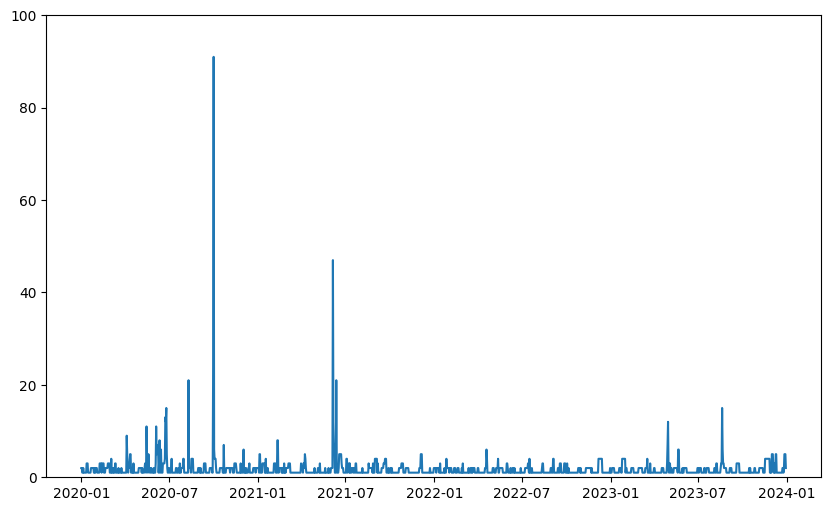

In [6]:
# plot the number of events per day
plt.figure(figsize=(10, 6))
plt.plot(event_counts_df.index, event_counts_df['target'])
plt.ylim([0, 100])

In [7]:
print(ChronosPipeline.predict.__doc__)


        Get forecasts for the given time series.

        Parameters
        ----------
        context
            Input series. This is either a 1D tensor, or a list
            of 1D tensors, or a 2D tensor whose first dimension
            is batch. In the latter case, use left-padding with
            ``torch.nan`` to align series of different lengths.
        prediction_length
            Time steps to predict. Defaults to what specified
            in ``self.model.config``.
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            

In [16]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

    # torch_dtype=torch.bfloat16,

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# forecast shape: [num_series, num_samples, prediction_length]
forecast = pipeline.predict(
    context=torch.tensor(event_counts_df["target"].values[:-prediction_length], dtype=torch.float32),
    prediction_length=prediction_length,
    num_samples=20,
)

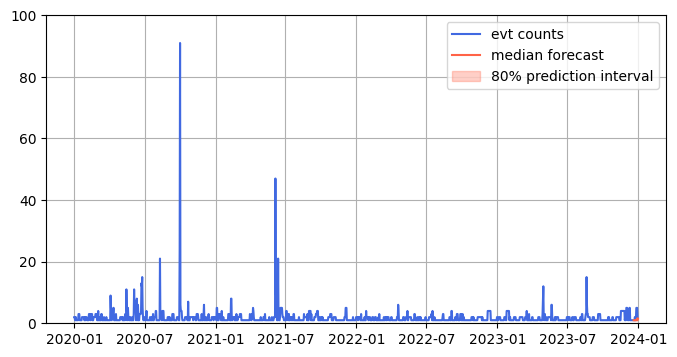

In [12]:
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import numpy as np

forecast_index = range(len(event_counts_df), len(event_counts_df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)


# Assuming event_counts_df is your DataFrame with a datetime index
# Get the last date from the event_counts_df index
last_date = event_counts_df.index[-60]


# Create a new date range for the forecast
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='D')

plt.figure(figsize=(8, 4))
plt.plot(event_counts_df["target"], color="royalblue", label="evt counts")
plt.plot(forecast_dates, median, color="tomato", label="median forecast")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.ylim([0,100])
plt.show()

In [41]:
import pandas as pd

# Assuming event_counts is a dictionary with dates as keys and counts as values
# Convert the dictionary to a DataFrame
event_counts_df = pd.DataFrame(list(event_counts.items()), columns=['date', 'count'])

# Convert the date column to datetime
event_counts_df['date'] = pd.to_datetime(event_counts_df['date'])

# Normalize the dates to the first day of the month
event_counts_df['month'] = event_counts_df['date'].dt.to_period('M')

# Aggregate the counts by month
monthly_event_counts = event_counts_df.groupby('month')['count'].sum().reset_index()

# Convert the 'month' column back to datetime for easier plotting
monthly_event_counts['month'] = monthly_event_counts['month'].dt.to_timestamp()

print(monthly_event_counts)

        month  count
0  2020-01-01     30
1  2020-02-01     29
2  2020-03-01     25
3  2020-04-01     48
4  2020-05-01     55
5  2020-06-01    128
6  2020-07-01     29
7  2020-08-01     47
8  2020-09-01     44
9  2020-10-01    127
10 2020-11-01     25
11 2020-12-01     35
12 2021-01-01     27
13 2021-02-01     33
14 2021-03-01     18
15 2021-04-01     30
16 2021-05-01     20
17 2021-06-01    115
18 2021-07-01     34
19 2021-08-01     27
20 2021-09-01     25
21 2021-10-01     23
22 2021-11-01     11
23 2021-12-01     21
24 2022-01-01     27
25 2022-02-01     18
26 2022-03-01     25
27 2022-04-01     22
28 2022-05-01     22
29 2022-06-01     20
30 2022-07-01     22
31 2022-08-01     16
32 2022-09-01     22
33 2022-10-01     18
34 2022-11-01      7
35 2022-12-01     14
36 2023-01-01     14
37 2023-02-01     15
38 2023-03-01     17
39 2023-04-01     35
40 2023-05-01     28
41 2023-06-01     13
42 2023-07-01     11
43 2023-08-01     43
44 2023-09-01     14
45 2023-10-01     14
46 2023-11-01

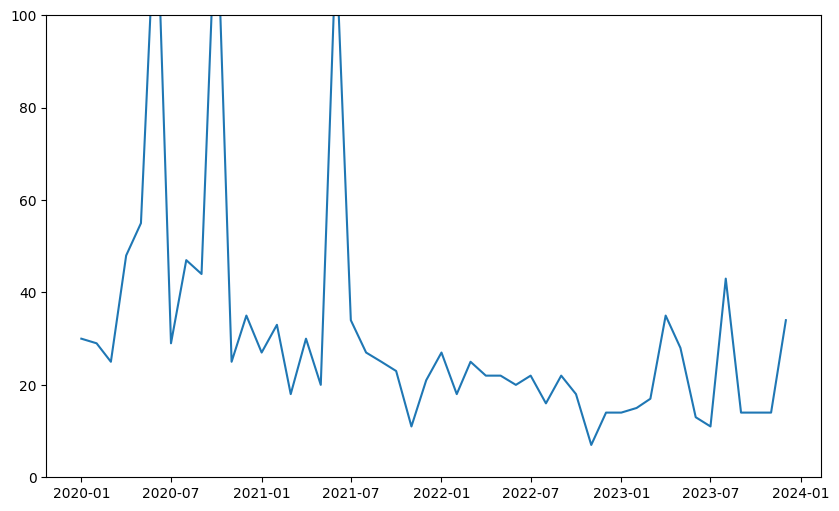

In [20]:
# plot the number of events per month
plt.figure(figsize=(10, 6))
plt.plot(monthly_event_counts['month'], monthly_event_counts['count'])
plt.ylim([0, 100])
# plt.plot( event_counts_df['count'])
plt.show()

In [29]:
prediction_length = 12
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# forecast shape: [num_series, num_samples, prediction_length]
forecast = pipeline.predict(
    context=torch.tensor(monthly_event_counts["count"].values[:-prediction_length], dtype=torch.float32),
    prediction_length=prediction_length,
    num_samples=20,
)

In [42]:
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import numpy as np

forecast_index = range(len(monthly_event_counts), len(monthly_event_counts) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)


# Assuming event_counts_df is your DataFrame with a datetime index
# Get the last date from the event_counts_df index
# set month as the index of the dataframe
monthly_event_counts = monthly_event_counts.set_index('month')
# and remove month as the index name
# monthly_event_counts.index.name = None
last_date = monthly_event_counts.index[-prediction_length]


# Create a new date range for the forecast
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_length, freq='M')


KeyError: 'target'

<Figure size 800x400 with 0 Axes>

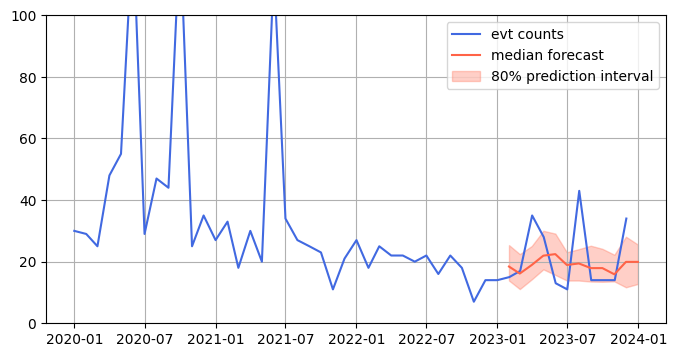

In [43]:

plt.figure(figsize=(8, 4))
plt.plot(monthly_event_counts["count"], color="royalblue", label="evt counts")
plt.plot(forecast_dates, median, color="tomato", label="median forecast")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.ylim([0,100])
plt.show()